# Exploratory Data Analysis (EDA) for Insurance Fraud Dataset

This notebook explores the cleaned **Insurance Claims** Dataset to understand:
- **Data Structure** and **Summary Statistics**
- `Fraud` vs `non-fraud` **Distribution** and **Imbalance**
- **Distribution** of key **Numeric Features**
- **Relationships** between **Features** and **Fraud**
- **Categorical** **Feature Analysis**
- **Time-based** **Trends** (if available)
- **Outlier** **Detection**

I use `pandas` for **Data Manipulation** and `seaborn`/`matplotlib` for **Visualization**.

## Table of Contents
1. Load Data and Basic Inspection  
2. Data Overview and Summary Statistics  
3. Fraud Class Distribution  
4. Convert Fraud Labels for Numeric Analysis  
5. Numeric Feature Exploration  
6. Categorical Feature Exploration  
7. Time-Based Trends 
8. EDA Summary and Next Steps

In [1]:
# Import essential libraries
import pandas as pd                                 # For data manipulation
import seaborn as sns                               # For statistical visualizations
import numpy as np                                  # For numerical operations
import matplotlib.pyplot as plt                     # For basic plotting
import os                                           # For file path handling
from IPython.display import display, Markdown       # For displaying Markdown and DataFrames in Jupyter

# Set Seaborn's visual style for cleaner plots
sns.set(style="whitegrid")

# Enable inline plotting for Jupyter
%matplotlib inline

### 1. Load Data and Basic Inspection

In this step, I load the cleaned insurance claims dataset from a CSV file saved from the ETL process into a pandas DataFrame. I also inspect the shape (rows, columns) to understand dataset size and display the first few rows to get an initial feel for the data’s structure and content.

In [2]:
# Define project directory and cleaned data path
project_dir = r"C:\Users\Cloud\OneDrive\Desktop\Fraud_Analytics_Project"
cleaned_file = os.path.join(project_dir, "data", "cleaned", "cleaned_insurance_claims.csv")

# Load cleaned dataset with date parsing for incident_date and policy_bind_date
try:
    # Attempt to load the cleaned dataset, parsing dates in specified columns
    df = pd.read_csv(cleaned_file, parse_dates=['incident_date', 'policy_bind_date'])
    # This will inform me that the file was loaded successfully with the exact path.
    display(Markdown(f"**Loaded data from:** `{cleaned_file}`"))
except FileNotFoundError:
    # This line catches the specific error when the file is not found.
    display(Markdown(f"**Error:** File not found at `{cleaned_file}`. Please check the file path."))
    # Raise error or exit
    raise
except Exception as e:
    # Catches any other unexpected exceptions during file loading.
    display(Markdown(f"**Error loading data:** {e}"))
    # Raises the error again after displaying the message.
    raise

# Display dataframe shape
display(Markdown("**Dataframe shape:**"))
display(df.shape)

# Show first 5 rows for initial inspection
display(Markdown("**First 5 rows:**"))
display(df.head())

# Show dataframe info for datatypes and non-null counts
display(Markdown("**Dataframe info:**"))
df.info()

# Confirm 'fraud_reported' column is numeric and show value counts
display(Markdown("**Fraud reported value counts:**"))
display(df['fraud_reported'].value_counts())

# Optionally create a human-readable label for plotting convenience
df['fraud_label'] = df['fraud_reported'].map({0: 'No', 1: 'Yes'})

# Display sample of fraud_reported and fraud_label columns
display(Markdown("**Sample fraud_reported and fraud_label:**"))
display(df[['fraud_reported', 'fraud_label']].head())

**Loaded data from:** `C:\Users\Cloud\OneDrive\Desktop\Fraud_Analytics_Project\data\cleaned\cleaned_insurance_claims.csv`

**Dataframe shape:**

(1000, 46)

**First 5 rows:**

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,auto_model,auto_year,fraud_reported,collision_type_missing_flag,police_report_available_missing_flag,property_damage_missing_flag,authorities_contacted_missing_flag,policy_csl_min,policy_csl_max,risk_score
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,92X,2004,1,0,0,0,0,250,500,2
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,E400,2007,1,0,0,0,0,250,500,0
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,RAM,2007,0,0,0,0,0,100,300,2
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,TAHOE,2014,1,0,0,0,0,250,500,3
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,RSX,2009,0,0,0,0,0,500,1000,1


**Dataframe info:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 46 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   months_as_customer                    1000 non-null   int64         
 1   age                                   1000 non-null   int64         
 2   policy_number                         1000 non-null   int64         
 3   policy_bind_date                      1000 non-null   datetime64[ns]
 4   policy_state                          1000 non-null   object        
 5   policy_csl                            1000 non-null   object        
 6   policy_deductable                     1000 non-null   int64         
 7   policy_annual_premium                 1000 non-null   float64       
 8   umbrella_limit                        1000 non-null   int64         
 9   insured_zip                           1000 non-null   int64         
 10  i

**Fraud reported value counts:**

fraud_reported
0    753
1    247
Name: count, dtype: int64

**Sample fraud_reported and fraud_label:**

,fraud_reported,fraud_label
0,1,Yes
1,1,Yes
2,0,No
3,1,Yes
4,0,No


In [3]:
[col for col in df.columns if 'missing' in col.lower()]

['collision_type_missing_flag',
 'police_report_available_missing_flag',
 'property_damage_missing_flag',
 'authorities_contacted_missing_flag']

### 2. Data Overview and Summary Statistics

Here, I review the dataset's structure using `info()` to check data types and missing values. I then display summary statistics (mean, median, quartiles, etc.) for numeric columns, helping me understand feature distributions and spot anomalies.

In [4]:
# Count how many missing values in each column, sorted descending
missing_counts = df.isna().sum().sort_values(ascending=False)

# Calculate percentage of missing values relative to total rows, rounded to 2 decimals
missing_percent = (missing_counts / len(df) * 100).round(2)

# Combine missing counts and percentages into a DataFrame for easier viewing
missing_summary = pd.DataFrame({'Missing Count': missing_counts, 'Missing %': missing_percent})

# Display missing value summary table
display(missing_summary)

# List all columns that have any missing values
cols_with_missing = missing_counts[missing_counts > 0].index.tolist()
display(Markdown(f"**Columns with missing values:** {cols_with_missing}"))

,Missing Count,Missing %
property_damage,360,36.0
police_report_available,343,34.3
collision_type,178,17.8
months_as_customer,0,0.0
incident_location,0,0.0
number_of_vehicles_involved,0,0.0
bodily_injuries,0,0.0
witnesses,0,0.0
total_claim_amount,0,0.0
injury_claim,0,0.0


**Columns with missing values:** ['property_damage', 'police_report_available', 'collision_type']

### 3. Fraud Class Distribution

In this section, I explore the distribution of fraudulent vs non-fraudulent claims.
This is important because fraud datasets are often **imbalanced**, which can affect model performance. I show both the **counts and percentages** of each class, and visualize the imbalance using an annotated bar chart.

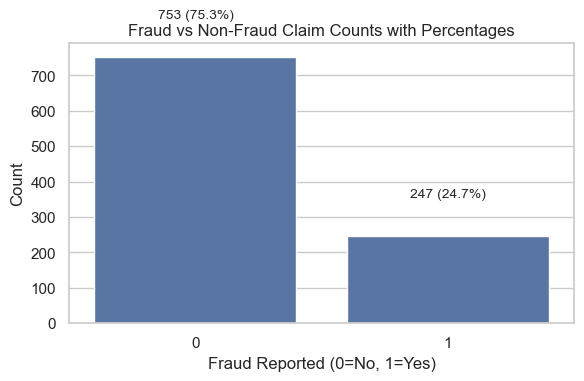

### Fraud Class Breakdown

fraud_reported
0    753
1    247
Name: count, dtype: int64

**Class imbalance ratio (majority/minority):** 3.05

In [5]:
# Count number of fraud (1) and non-fraud (0) cases
fraud_counts = df['fraud_reported'].value_counts().sort_index()
fraud_percentages = (fraud_counts / fraud_counts.sum() * 100).round(2)

# Plot countplot using numeric labels and annotated percentages
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='fraud_reported', data=df)

# Annotate each bar with count and percentage
for i, count in enumerate(fraud_counts):
    percent = fraud_percentages[i]
    ax.text(i, count + 100, f"{count} ({percent}%)", ha='center', va='bottom', fontsize=10)

plt.title('Fraud vs Non-Fraud Claim Counts with Percentages')
plt.xlabel('Fraud Reported (0=No, 1=Yes)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
plt.close()

# Display fraud counts and imbalance ratio
display(Markdown("### Fraud Class Breakdown"))
display(fraud_counts)
imbalance_ratio = fraud_counts.max() / fraud_counts.min()
display(Markdown(f"**Class imbalance ratio (majority/minority):** {imbalance_ratio:.2f}"))

### 4. Convert Fraud Labels for Numeric Analysis

The `fraud_reported` column is already numeric (`0` for non-fraud, `1` for fraud).  
To ensure compatibility with modeling workflows and visual consistency, I duplicate it to a new column `fraud_numeric`.

In [6]:
# Duplicate the 'fraud_reported' column to a new 'fraud_numeric' column for clarity in modeling workflows
df['fraud_numeric'] = df['fraud_reported']

# Display the first 5 rows of all three columns to confirm the transformation
display(df[['fraud_reported', 'fraud_numeric', 'fraud_label']].head())

,fraud_reported,fraud_numeric,fraud_label
0,1,1,Yes
1,1,1,Yes
2,0,0,No
3,1,1,Yes
4,0,0,No


### 5. Numeric Feature Exploration

In this section, I explore key **numerical features** to better understand:

- Their **distributions** across all claims (normality, skewness, shape)
- Their **relationship to fraud** using boxplots by fraud label
- The presence of **outliers** that may signal unusual or fraudulent activity

These insights are essential for:
- Identifying features that may help differentiate fraud vs. non-fraud claims
- Detecting values that require **transformation or scaling** before modeling
- Understanding **data quality issues**, like impossible values (e.g., invalid hours)

### Key Features Analyzed:
- `total_claim_amount` – amount claimed by policyholder  
- `incident_hour_of_the_day` – time of day when the incident occurred  
- `risk_score` – engineered fraud risk signal created during ETL

---
> NOTE:
> High-value claims and incidents occurring late at night are often considered red flags in insurance fraud.  
> This numeric feature exploration helps us **quantify how such risk related variables behave**,  
> and whether they demonstrate **distinct patterns between fraudulent and non-fraudulent claims**.
---

**Invalid 'incident_hour_of_the_day' entries detected:** 0

### Descriptive Statistics

,count,mean,std,min,25%,50%,75%,max
total_claim_amount,1000.0,52761.940,26401.533190,100.0,41812.5,58055.0,70592.5,114920.0
incident_hour_of_the_day,1000.0,11.644,6.951373,0.0,6.0,12.0,17.0,23.0
risk_score,1000.0,1.410,0.704554,0.0,1.0,1.0,2.0,3.0


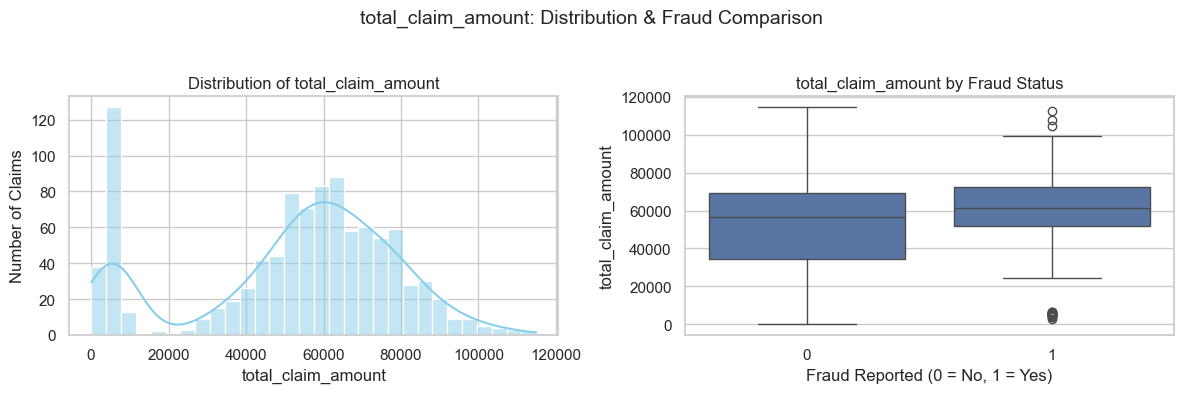

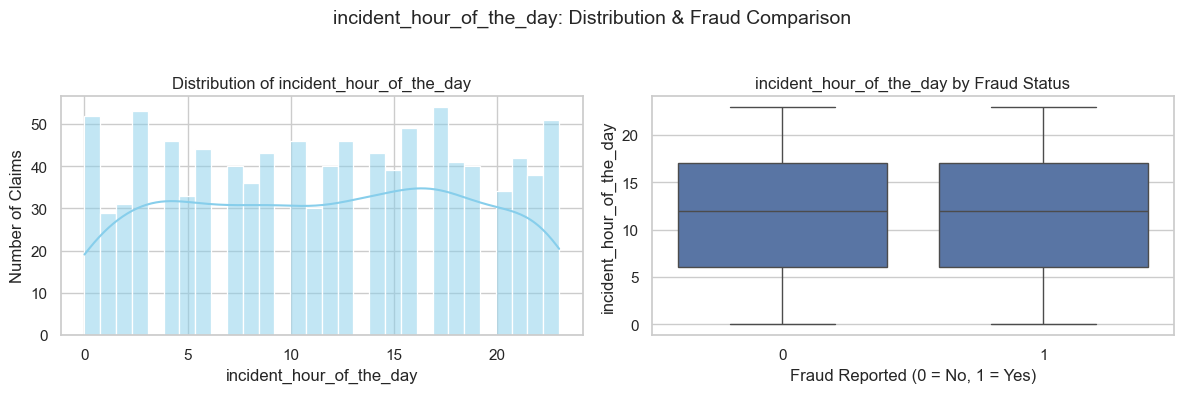

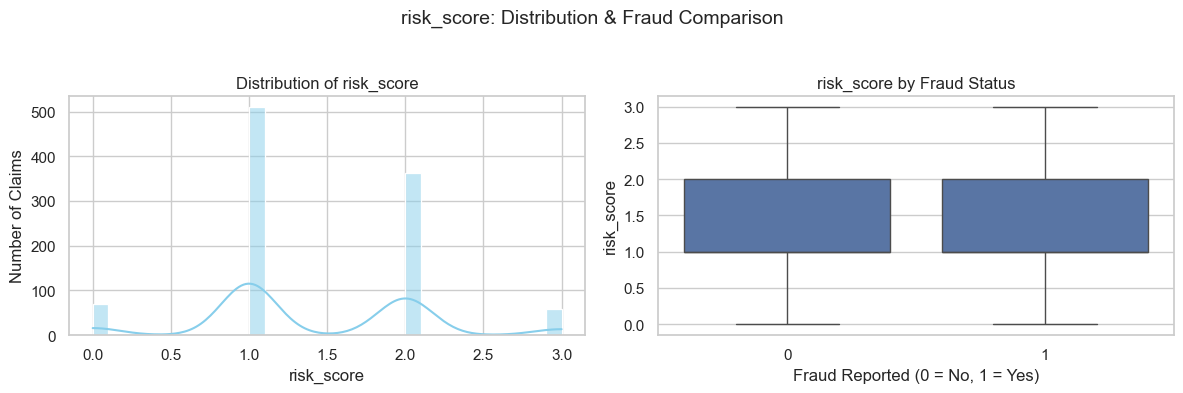

### Correlation Heatmap of Numeric Features

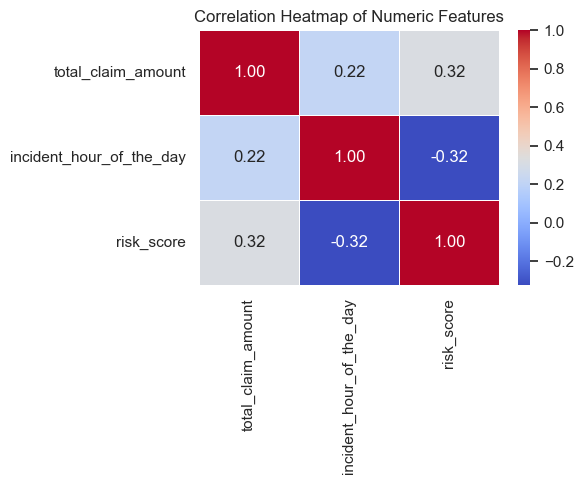

### Top 5 Largest Claims with Details

,total_claim_amount,fraud_reported,incident_type,collision_type
11,114920,0,MULTI-VEHICLE COLLISION,FRONT COLLISION
149,112320,1,SINGLE VEHICLE COLLISION,SIDE COLLISION
996,108480,0,SINGLE VEHICLE COLLISION,REAR COLLISION
565,108030,0,SINGLE VEHICLE COLLISION,SIDE COLLISION
163,107900,1,SINGLE VEHICLE COLLISION,FRONT COLLISION


In [7]:
# List of important numeric features to analyze
numeric_features = ['total_claim_amount', 'incident_hour_of_the_day', 'risk_score']

# Check for impossible or invalid hour values (should be between 0 and 23)
invalid_hours = df[(df['incident_hour_of_the_day'] < 0) | (df['incident_hour_of_the_day'] > 23)]
display(Markdown(f"**Invalid 'incident_hour_of_the_day' entries detected:** {len(invalid_hours)}"))

# If invalid entries exist, display a sample for debugging
if len(invalid_hours) > 0:
    display(Markdown("### Sample invalid 'incident_hour_of_the_day' rows"))
    display(invalid_hours.head())

# Generate descriptive statistics (mean, std, min/max, quartiles) for numeric features
display(Markdown("### Descriptive Statistics"))
display(df[numeric_features].describe().T)

# Visualize distribution and fraud-based separation for each numeric feature
for feature in numeric_features:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Plot histogram with KDE to visualize overall distribution
    sns.histplot(df[feature], bins=30, kde=True, color='skyblue', ax=axs[0])
    axs[0].set_title(f'Distribution of {feature}')
    axs[0].set_xlabel(feature)
    axs[0].set_ylabel('Number of Claims')
    axs[0].grid(True)

    # Plot boxplot split by fraud class to detect shifts or differences in distributions
    sns.boxplot(x='fraud_numeric', y=feature, data=df, ax=axs[1])
    axs[1].set_title(f'{feature} by Fraud Status')
    axs[1].set_xlabel('Fraud Reported (0 = No, 1 = Yes)')
    axs[1].set_ylabel(feature)

    # Set overall plot title
    plt.suptitle(f'{feature}: Distribution & Fraud Comparison', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reserve space for title
    plt.show()
    plt.close()
    
# Correlation Heatmap for Numeric Features
display(Markdown("### Correlation Heatmap of Numeric Features"))

# Compute correlation matrix for numeric features
corr_matrix = df[numeric_features].corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()
plt.close()

# Display top 5 largest claims with relevant details for context
top_5_claims = df.nlargest(5, 'total_claim_amount')

# Select columns of interest for context, adjust as per your dataset
cols_to_show = ['claim_number', 'total_claim_amount', 'fraud_reported', 'incident_type', 'collision_type']

# Check if all columns exist, otherwise adjust cols_to_show
existing_cols = [col for col in cols_to_show if col in df.columns]

# Display the top 5 claims with selected columns
display(Markdown("### Top 5 Largest Claims with Details"))
display(top_5_claims[existing_cols])

### 6. Categorical Feature Analysis: Fraud Relationships

This section investigates how key **categorical features** relate to fraud, using both visual and statistical analysis.

### Goals:
- Explore how categories (e.g., collision type) distribute across fraud and non-fraud cases
- Identify categories with **higher fraud rates**
- Visualize **fraud proportions** using stacked bar charts
- Examine whether **missing categorical values** signal higher fraud likelihood

These features are domain-relevant and often cited in insurance fraud studies:
- `incident_type`: Type of incident may influence likelihood of fraudulent reporting.
- `collision_type`: Specific collisions may be staged or prone to fraud.
- `police_report_available`: Lack of police involvement may indicate suspicious behavior.

Key components of this section:
- **Countplots** showing category distribution across fraud vs. non-fraud
- **Fraud rate tables** sorted by likelihood across categories
- **Stacked bar charts** for visualizing proportion of fraud in each category
- **Missing value flags** analyzed for hidden fraud signals

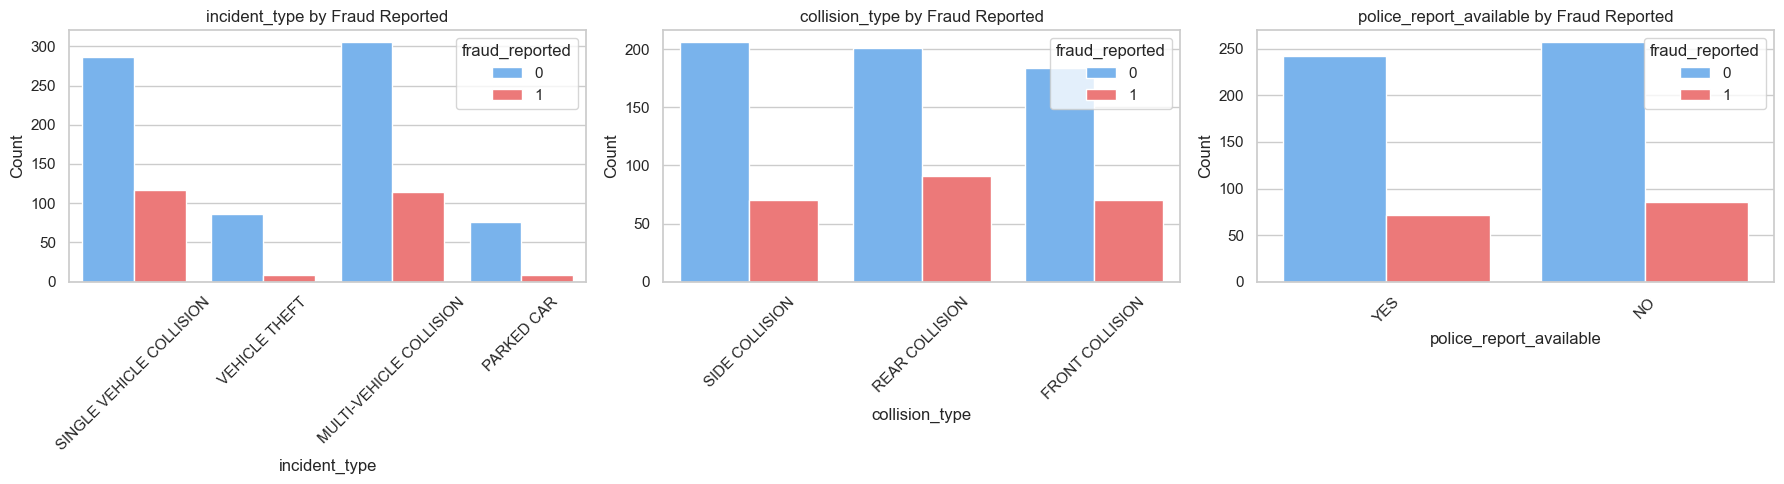

### Fraud Rate Summary for `incident_type`

_Sorted descending by fraud rate to highlight categories with highest fraud risk._

,count,fraud_rate
incident_type,,
SINGLE VEHICLE COLLISION,403,0.290323
MULTI-VEHICLE COLLISION,419,0.272076
PARKED CAR,84,0.095238
VEHICLE THEFT,94,0.085106


### Fraud Rate Summary for `collision_type`

_Sorted descending by fraud rate to highlight categories with highest fraud risk._

,count,fraud_rate
collision_type,,
REAR COLLISION,292,0.311644
FRONT COLLISION,254,0.275591
SIDE COLLISION,276,0.253623


### Fraud Rate Summary for `police_report_available`

_Sorted descending by fraud rate to highlight categories with highest fraud risk._

,count,fraud_rate
police_report_available,,
NO,343,0.250729
YES,314,0.229299


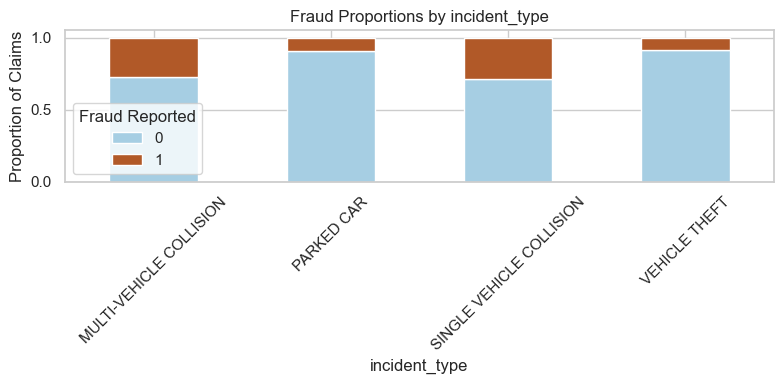

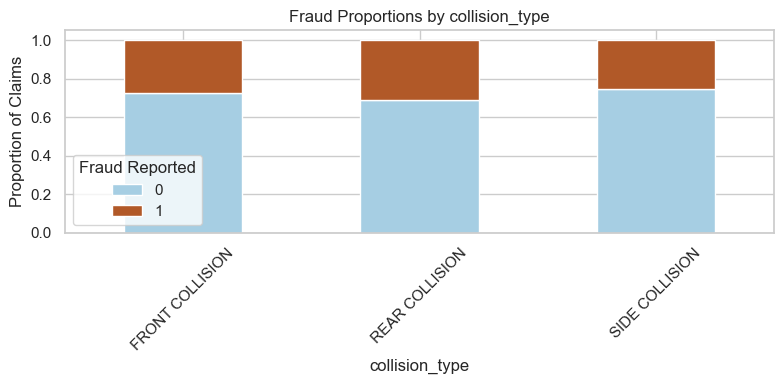

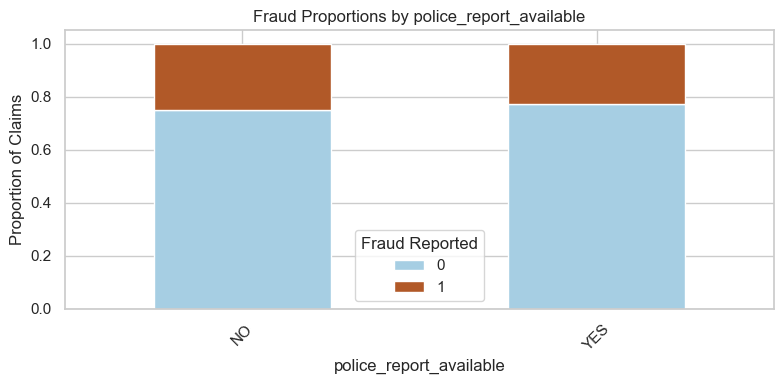

### Impact of Missing Values on Fraud Rate

#### Fraud Rate by `collision_type_missing_flag`

,count,fraud_rate
collision_type_missing_flag,,
0,1000,0.247


#### Fraud Rate by `police_report_available_missing_flag`

,count,fraud_rate
police_report_available_missing_flag,,
0,1000,0.247


In [8]:
# Define relevant categorical features for fraud analysis
categorical_features = ['incident_type', 'collision_type', 'police_report_available']

# 1. Plot frequency of each category split by fraud label
plt.figure(figsize=(18, 5))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 3, i)
    sns.countplot(x=feature, hue='fraud_reported', data=df, palette=['#66b3ff', '#ff6666'])
    plt.title(f'{feature} by Fraud Reported')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

# 2. Show fraud rate by category (sorted high to low)
for feature in categorical_features:
    summary = df.groupby(feature).agg(
        count=(feature, 'size'),
        fraud_rate=('fraud_numeric', 'mean')
    ).sort_values('fraud_rate', ascending=False)
    
    display(Markdown(f"### Fraud Rate Summary for `{feature}`"))
    display(Markdown("_Sorted descending by fraud rate to highlight categories with highest fraud risk._"))
    display(summary)

# 3. Visualize fraud vs. non-fraud proportions per category
for feature in categorical_features:
    crosstab = pd.crosstab(df[feature], df['fraud_reported'], normalize='index')
    crosstab.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='Paired')
    plt.title(f'Fraud Proportions by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Proportion of Claims')
    plt.legend(title='Fraud Reported')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.close()

# 4. Check how missing value flags relate to fraud rates
display(Markdown("### Impact of Missing Values on Fraud Rate"))

# List of expected missing value indicator columns
missing_flags = ['collision_type_missing_flag', 'police_report_available_missing_flag']

for flag_col in missing_flags:
    if flag_col in df.columns:
        # Group by missing flag: count cases and calculate fraud rate
        summary = df.groupby(flag_col).agg(
            count=('fraud_reported', 'size'),
            fraud_rate=('fraud_reported', 'mean')
        ).sort_index(ascending=False)  # Show True (missing) first

        display(Markdown(f"#### Fraud Rate by `{flag_col}`"))
        display(summary)
    else:
        display(Markdown(f"`{flag_col}` not found in dataset. Make sure it was created during ETL."))

## 7. Time Based Trends

Analyzing fraud trends over time may reveal seasonal spikes, evolving fraud tactics, or reporting delays. This insight supports operational decisions, such as increasing fraud monitoring during certain periods.

**Rows with invalid 'incident_date' removed:** 0

**Note:** The plot shows daily claim counts, which can be noisy. Consider aggregating by week or month or applying smoothing for clearer trends.

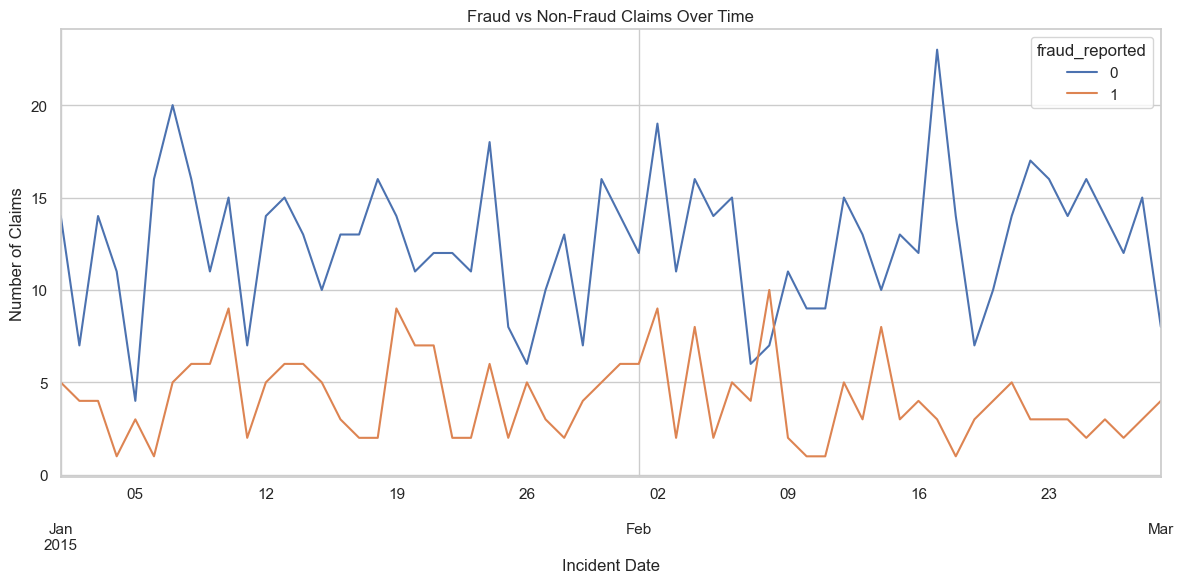

In [9]:
if 'incident_date' in df.columns:
    # Convert incident_date to datetime (handle errors by coercing invalid formats to NaT)
    df['incident_date'] = pd.to_datetime(df['incident_date'], errors='coerce')
    
    # Count how many rows will be dropped due to invalid date
    num_invalid_dates = df['incident_date'].isna().sum()
    display(Markdown(f"**Rows with invalid 'incident_date' removed:** {num_invalid_dates}"))

    # Drop rows where incident_date could not be parsed
    time_df = df.dropna(subset=['incident_date'])
    
    # Group by date and fraud status to count claims per day
    fraud_over_time = time_df.groupby(['incident_date', 'fraud_reported']).size().unstack(fill_value=0)
    
    # Add a note about the aggregation granularity and noise
    display(Markdown(
        "**Note:** The plot shows daily claim counts, which can be noisy. " 
        "Consider aggregating by week or month or applying smoothing for clearer trends."
    ))
    
    # Plot fraud and non-fraud claims over time
    plt.figure(figsize=(12, 6))
    fraud_over_time.plot(ax=plt.gca())
    plt.title('Fraud vs Non-Fraud Claims Over Time')
    plt.xlabel('Incident Date')
    plt.ylabel('Number of Claims')
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    display(Markdown("**No 'incident_date' column available to analyze time trends.**"))

# EDA Summary

- Assessed data quality and handled missing values  
- Explored fraud class imbalance and its implications  
- Analyzed numeric and categorical feature distributions  
- Investigated relationships between key features and fraud  
- Evaluated the impact of missing or placeholder values on fraud rates  
- Visualized time based trends and identified potential outliers

---

## Next Steps

- Engineer and select predictive features  
- Prepare data for machine learning through train/test split  
- Train and evaluate classification models to detect fraud

---

## Transition to Modeling

The fraud detection pipeline continues in:

- [`feature_engineering.ipynb`](./feature_engineering.ipynb): where I extract time based features, one-hot encode categorical variables, and create additional fraud signals  
- [`model_training.ipynb`](./model_training.ipynb): where I split the dataset, train baseline and advanced models, and evaluate fraud detection performance

These notebooks build on the insights gained in EDA to construct a high-performing, interpretable fraud detection model.